# Lesson 6-1: Dogs vs Cats

イヌとネコを見分けられるAIを作る。
ランタイムをGPUに切り替える。

## 1. 準備

### 1-1. Google Driveのマウント

In [1]:
import google.colab
f = google.colab.files.upload()

Saving dogs_vs_cats.zip to dogs_vs_cats.zip


### 1-2. dogs_vs_cats.zipの解凍
contentディレクトリ内にdogs_vs_catsディレクトリが作成され，画像ファイルが保存される

In [2]:
!unzip "dogs_vs_cats.zip"

Archive:  dogs_vs_cats.zip
  inflating: dogs_vs_cats/cat_00000.jpg  
  inflating: dogs_vs_cats/cat_00001.jpg  
  inflating: dogs_vs_cats/cat_00002.jpg  
  inflating: dogs_vs_cats/cat_00003.jpg  
  inflating: dogs_vs_cats/cat_00004.jpg  
  inflating: dogs_vs_cats/cat_00005.jpg  
  inflating: dogs_vs_cats/cat_00006.jpg  
  inflating: dogs_vs_cats/cat_00007.jpg  
  inflating: dogs_vs_cats/cat_00008.jpg  
  inflating: dogs_vs_cats/cat_00009.jpg  
  inflating: dogs_vs_cats/cat_00010.jpg  
  inflating: dogs_vs_cats/cat_00011.jpg  
  inflating: dogs_vs_cats/cat_00012.jpg  
  inflating: dogs_vs_cats/cat_00013.jpg  
  inflating: dogs_vs_cats/cat_00014.jpg  
  inflating: dogs_vs_cats/cat_00015.jpg  
  inflating: dogs_vs_cats/cat_00016.jpg  
  inflating: dogs_vs_cats/cat_00017.jpg  
  inflating: dogs_vs_cats/cat_00018.jpg  
  inflating: dogs_vs_cats/cat_00019.jpg  
  inflating: dogs_vs_cats/cat_00020.jpg  
  inflating: dogs_vs_cats/cat_00021.jpg  
  inflating: dogs_vs_cats/cat_00022.jpg  
  infla

### 1-3. ライブラリのインポート

In [3]:
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras.models import Sequential, load_model
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### 1-4. データのファイル数とパスの確認

In [4]:
#画像ファイルが入っているディレクトリの指定
DataDir = "dogs_vs_cats/"

# 画像ファイル名のリストを取得し，ファイルの数を確認。
FileNames = os.listdir(DataDir)
print("ファイル数:", len(FileNames))

#ファイル名リストの順番をシャッフル
random.shuffle(FileNames)

#ファイルパスのリストを生成
FilePathAll = []

for file in FileNames:
    Path = DataDir+file
    FilePathAll.append(Path)

#最初の10個のファイルパスを表示
FilePathAll[:10]

ファイル数: 1101


['dogs_vs_cats/cat_00078.jpg',
 'dogs_vs_cats/cat_00458.jpg',
 'dogs_vs_cats/dog_00237.jpg',
 'dogs_vs_cats/cat_00173.jpg',
 'dogs_vs_cats/cat_00260.jpg',
 'dogs_vs_cats/dog_00437.jpg',
 'dogs_vs_cats/dog_00525.jpg',
 'dogs_vs_cats/dog_00542.jpg',
 'dogs_vs_cats/cat_00101.jpg',
 'dogs_vs_cats/dog_00071.jpg']

### 1-5. データを表示してみる

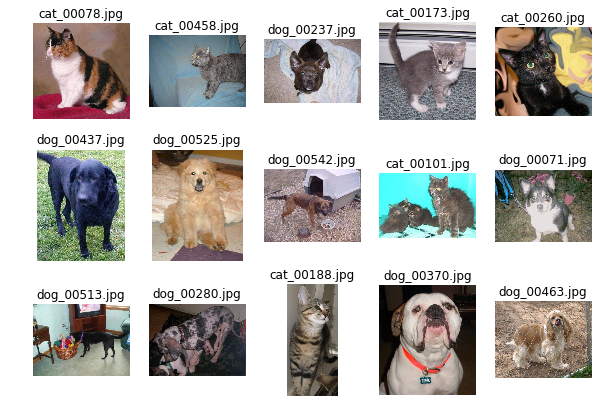

In [5]:
plt.figure(figsize=(10,7))
for i in range(15):
    FilePath = FilePathAll[i]
    FileName = os.path.basename(FilePath)
    img = cv2.imread(FilePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(FileName)
    plt.axis("off")

### 1-6. ファイルパスを学習データとテストデータ用に分離

In [6]:
N4test = 101
TestFilePath = FilePathAll[:N4test]
TrainFilePath = FilePathAll[N4test:]

print("学習データ数", len(TrainFilePath))
print("テストデータ数", len(TestFilePath))

学習データ数 1000
テストデータ数 101


### 1-7. データ読み取り後の画像サイズを設定

In [0]:
# 縦100ピクセル x 横100ピクセル
imgsize= 100

### 1-8. 学習データの読み込み

In [8]:
trainX = []
trainY = []

for FilePath in tqdm(TrainFilePath):
    img = cv2.imread(FilePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (imgsize, imgsize))
    img = img/255
    trainX.append(img)
    
    FileName = os.path.basename(FilePath)
    label = FileName.split("_")[0]
    
    if label == "dog":
        trainY.append(0)
    else:
        trainY.append(1)

trainY = to_categorical(trainY)

trainX = np.array(trainX)
trainY = np.array(trainY)

print("学習データの読み込み完了")
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)

100%|██████████| 1000/1000 [00:02<00:00, 438.43it/s]


学習データの読み込み完了
trainX shape: (1000, 100, 100, 3)
trainY shape: (1000, 2)


### 1-9. テストデータの読み込み

In [9]:
testX = []
testY = []

for FilePath in tqdm(TestFilePath):
    img = cv2.imread(FilePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (imgsize, imgsize))
    img = img/255
    testX.append(img)
    
    FileName = os.path.basename(FilePath)
    label = FileName.split("_")[0]
    if label == "dog":
        testY.append(0)
    else:
        testY.append(1)

testY = to_categorical(testY)


testX = np.array(testX)
testY = np.array(testY)

print("テストデータの読み込み完了")
print("testX shape:", testX.shape)
print("testY shape:", testY.shape)

100%|██████████| 101/101 [00:00<00:00, 419.23it/s]

テストデータの読み込み完了
testX shape: (101, 100, 100, 3)
testY shape: (101, 2)


## 2. 学習

### 2-1. モデル（Deep Neural Network，DNN）の構築

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(imgsize, imgsize, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(2, activation="softmax"))

W0902 02:07:11.455775 139961110251392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 02:07:11.500401 139961110251392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 02:07:11.507460 139961110251392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 02:07:11.554392 139961110251392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0902 02:07:11.680262 139961110251392 deprecation_wrapp

### 2-2. モデルのコンパイル

In [11]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4), metrics=['accuracy'])

model.summary()

W0902 02:07:15.296339 139961110251392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 02:07:15.307301 139961110251392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)      

### 2-3. モデルの学習（トレーニング）

In [17]:
history = model.fit(trainX, trainY,
                    batch_size=50, 
                    epochs=20,
                    validation_split=0.1, 
                    verbose=1, 
                    shuffle=True,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=5,  verbose=0, mode='auto')]
                    )

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 3s 4ms/step - loss: 0.6184 - acc: 0.6733 - val_loss: 0.6393 - val_acc: 0.6000
Epoch 2/20
900/900 [==============================] - 2s 3ms/step - loss: 0.6380 - acc: 0.6422 - val_loss: 0.6663 - val_acc: 0.6300
Epoch 3/20
900/900 [==============================] - 2s 3ms/step - loss: 0.5789 - acc: 0.7011 - val_loss: 0.6483 - val_acc: 0.6300
Epoch 4/20
900/900 [==============================] - 2s 3ms/step - loss: 0.5553 - acc: 0.6933 - val_loss: 0.6225 - val_acc: 0.6600
Epoch 5/20
900/900 [==============================] - 2s 3ms/step - loss: 0.5452 - acc: 0.7367 - val_loss: 0.6128 - val_acc: 0.6100
Epoch 6/20
900/900 [==============================] - 2s 3ms/step - loss: 0.5173 - acc: 0.7400 - val_loss: 0.5801 - val_acc: 0.6900
Epoch 7/20
900/900 [==============================] - 2s 3ms/step - loss: 0.4913 - acc: 0.7578 - val_loss: 0.6474 - val_acc: 0.6700
Epoch 8/20
900/900 [==========

### 2-4. 学習経過をグラフ化

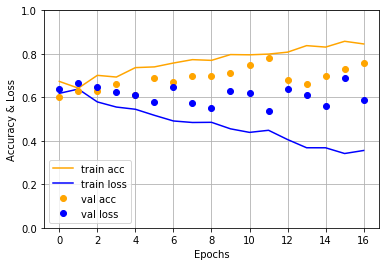

In [18]:
plt.figure(figsize=(6,4))

plt.plot(history.epoch, history.history["acc"], label="train acc", c="orange")
plt.plot(history.epoch, history.history["loss"], label="train loss", c="blue")

plt.plot(history.epoch, history.history["val_acc"], marker="o", lw=0, label="val acc", c="orange")
plt.plot(history.epoch, history.history["val_loss"], marker="o", lw=0, label="val loss", c="blue")

plt.ylim(0,1)

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

plt.legend()
plt.grid()

## 3. 推論 (Prediction)

### 3-1 testXのデータに対して学習済みモデルで推論する

In [0]:
predY = model.predict(testX)

### 3-2 推論結果（predY）の一部を可視化して確認する



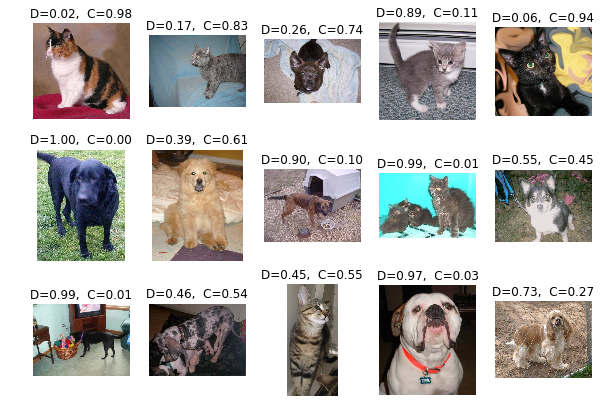

In [20]:
plt.figure(figsize=(10,7))
for i in range(15):
    FilePath = TestFilePath[i]
    img = cv2.imread(FilePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    score = predY[i, :]
    plt.title("D={:.2f},  C={:.2f}".format(score[0], score[1]))
    plt.axis("off")

### 3-3 すべてのテストデータ（testX）に対する分類精度を検証する

In [21]:
score = model.evaluate(testX, testY)
print("Accuracy = {:.2f}".format(score[1]))

101/101 [==============================] - 0s 1ms/step
Accuracy = 0.71


### 3-4 パスを指定して学習済みモデルを保存する

In [0]:
path = "gdrive/My Drive/DL超入門_DAY2/dog_vs_cat_model.h5"
model.save(path)